In [8]:
# import library
import json
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import seaborn as sn

In [9]:
# connect to gdrive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [13]:
DATA_PATH = "/content/gdrive/MyDrive/Dataset/go_left_right_stop.json"
SAVED_MODEL_PATH = "CNN_Journal.h5"
EPOCHS = 100
BATCH_SIZE = 16
PATIENCE = 10
LEARNING_RATE = 0.00001

In [14]:
def load_data(data_path):
    # load dataset from .json file with MFCCs and labels as parameters
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["MFCCs"])
    y = np.array(data["labels"])
    return X, y

In [15]:
def prepare_dataset(data_path, test_size=0.2, validation_size=0.20):

    # load dataset
    X, y = load_data(data_path)

    # train, test, validation split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=1)

    X_train = X_train[..., np.newaxis]
    X_test = X_test[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]

    return X_train, y_train, X_validation, y_validation, X_test, y_test

In [16]:
def build_model(input_shape, loss="sparse_categorical_crossentropy", learning_rate=0.0001):

    model = tf.keras.models.Sequential()

    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'))

    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(128, (2, 2), activation='relu',))
    model.add(tf.keras.layers.MaxPooling2D((2, 2), strides=(2,2), padding='same'))

    # flatten output and feed into dense layer
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(256, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    model.add(tf.keras.layers.Dense(128, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    model.add(tf.keras.layers.Dense(64, activation='relu'))
    tf.keras.layers.Dropout(0.3)

    # softmax output layer
    model.add(tf.keras.layers.Dense(4, activation='softmax'))
    optimiser = tf.optimizers.Adam(learning_rate=learning_rate)

    # compile model
    model.compile(optimizer=optimiser,
                  loss=loss,
                  metrics=["accuracy"])

    # print model parameters on console
    model.summary()

    return model

In [18]:
def train(model, epochs, batch_size, X_train, y_train, X_validation, y_validation, X_test, y_test):
    # model fit
    history = model.fit(X_train,
                        y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(X_validation, y_validation),
                        callbacks=TestCallback(X_test, y_test))
    return history

In [19]:
class TestCallback(tf.keras.callbacks.Callback):
  # initiate callbacks to evaluate model per epoch using test set data
    def __init__(self, X_test, y_test):
        self.test_data = X_test, y_test

    def on_epoch_end(self, epoch, logs):
        X_test, y_test = self.test_data
        loss, acc = self.model.evaluate(X_test, y_test, verbose=0)
        logs['test_accuracy'] = acc

In [20]:
def plot_history(history):

    fig, axs = plt.subplots(2)

    # create accuracy subplot
    axs[0].plot(history.history["accuracy"], label="accuracy")
    axs[0].plot(history.history['val_accuracy'], label="val_accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy evaluation")

    # create loss subplot
    axs[1].plot(history.history["loss"], label="loss")
    axs[1].plot(history.history['val_loss'], label="val_loss")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Loss")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss evaluation")

    plt.show()

In [21]:
def main():
    # generate train, validation and test sets
    X_train, y_train, X_validation, y_validation, X_test, y_test = prepare_dataset(DATA_PATH)
    
    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape, learning_rate=LEARNING_RATE)

    # train network
    history = train(model, EPOCHS, BATCH_SIZE, X_train, y_train, X_validation, y_validation, X_test, y_test)

    # plot accuracy/loss for training/validation set as a function of the epochs
    plot_history(history)

    # evaluate network on test set
    test_loss, test_acc = model.evaluate(X_test, y_test)
    print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc))

    print(input_shape)
    # save model
    model.save(SAVED_MODEL_PATH)
    
    y_predicted = model.predict(X_test)
    y_predicted_labels = [np.argmax(i) for i in y_predicted]
    cm = tf.math.confusion_matrix(labels=y_test, predictions=y_predicted_labels)
    
    plt.figure(figsize = (10,7))
    sn.heatmap(cm, cmap='Greys', annot=True, fmt='d')
    plt.title('Confusion Matrix') 
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 42, 11, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 21, 6, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 19, 4, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 2, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 1, 128)         32896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 5, 1, 128)        0

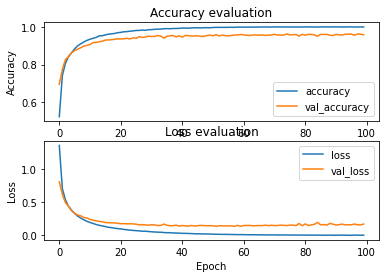

88/88 [==============================] - 0s 3ms/step - loss: 0.1851 - accuracy: 0.9596

Test loss: 0.18510212004184723, test accuracy: 95.96284627914429
(44, 13, 1)
88/88 [==============================] - 0s 2ms/step


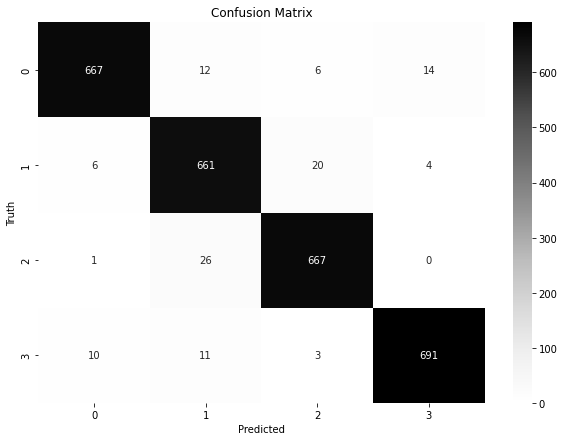

In [22]:
if __name__ == "__main__":
    main()